In [1]:
import pandas as pd
import string
import nltk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle 

from tqdm import tqdm
from random import choices
from scipy.sparse import dok_matrix
from scipy.spatial.distance import euclidean
from tensorflow.keras import layers, models, losses

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from preprocessing import *

In [2]:
df = pd.read_csv("data/emails.csv")
X = df.Text
y = df.Spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Preprocessing
- Get the vocabulary of the training set
- Create functions to convert integers to respective words and vice-versa

In [3]:
all_words, emails = process_documents(X_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4582/4582 [00:42<00:00, 108.08it/s]


In [4]:
rev_words = {item[1]:item[0] for item in all_words.items()}

In [5]:
M = len(all_words)

In [6]:
M

30442

In [7]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

## GloVe Embedding
- We will try to detect for ham or spam using GloVe representation

First we need to create the word representations

In [8]:
def count_word_coocurrence(docs, vocab, wsize=10):
    term_term_dict = {}
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                term_term_dict[ (prev_word, current_word) ] = term_term_dict.get(
                    (prev_word, current_word),
                    0
                ) + 1
                term_term_dict[ (future_word, current_word) ] = term_term_dict.get(
                    (future_word, current_word),
                    0
                ) + 1
                
    M = len(vocab)
    term_term_sparse = dok_matrix((M,M))
    for idx, value in term_term_dict.items():
        i, j = idx
        term_term_sparse[i, j] = value
        
    return term_term_sparse

In [9]:
word_cooc_matrix = count_word_coocurrence(emails, all_words, wsize=5)

In [10]:
def get_training_sets(cooc: dok_matrix):
    X = np.array(
        list(
            cooc.keys()
        )
    )
    y = np.array(
        list(
            cooc.values()
        )
    )
    
    return X, y

In [11]:
X, y = get_training_sets(word_cooc_matrix)

In [12]:
X.shape

(770585, 2)

In [13]:
#small embedding dim since the dataset is small
EMB_SIZE=50

In [14]:
target = layers.Input(shape=1, name="context_input")
context = layers.Input(shape=1, name="target_input")

embed_layer = layers.Embedding(
    input_dim=word_cooc_matrix.shape[0], 
    output_dim=EMB_SIZE, 
    name="embed"
)

embed_target = embed_layer(target)
embed_context = embed_layer(context)

dot = layers.Dot(axes=2)( [ embed_target, embed_context ] )
flat = layers.Flatten()(dot)

model = models.Model(inputs=[ target, context ], outputs=flat)

In [15]:
@tf.function
def loss(y_test, preds):
    x_max = 100
    α = 0.75
    
    G = tf.where(y_test < x_max, (y_test/x_max)**α, 1)
    temp = tf.math.log(y_test)
    
    return tf.reduce_sum(
      G *(preds - temp)**2  
    )

In [16]:
model.compile(optimizer="adam", loss=loss)

In [24]:
model.fit([ X[:,0], X[:,1] ], y, epochs=1, batch_size=64)

12041/12041 [==============================] - 76s 6ms/step - loss: 0.6544


In [25]:
embed_vectors = model.get_weights()[0]
u = PCA().fit_transform(embed_vectors)

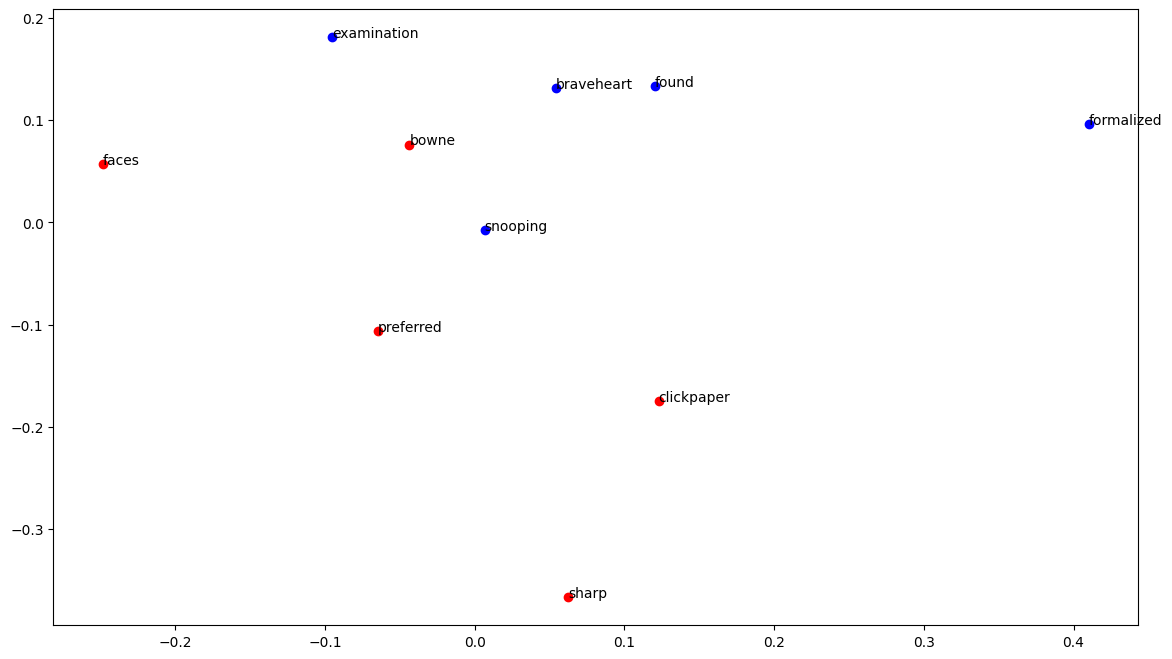

In [28]:
prog_near = np.argsort([ 
    euclidean(
        u[word2int("found")], 
        u[i]
    ) for i in range(len(u))
])[:5]

random = np.random.choice(list(range(len(u))), size=5, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(u[i,0], u[i,1], c="b") #int2word(i))
    plt.text(u[i,0], u[i,1],int2word(i))
    
for i in random:
    plt.scatter(u[i,0], u[i,1], c="r") 
    plt.text(u[i,0], u[i,1],int2word(i))

In [29]:
np.save("./data/glove_vectors.npy", embed_vectors)

## Continuous Bag of Words Embedding

In [40]:
def get_dataset(docs, wsize=2):
    dataset = {}
    
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            context_set = tuple()
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                context_set = context_set + (prev_word, future_word)
            context_set = tuple(sorted(context_set))
            
            dataset[context_set] = dataset.get(context_set, set()) | {current_word}
    return dataset

In [41]:
def unwind(dataset: dict):
    X = []
    y = []
    
    for item in dataset.items():
        xsample, ysamples = item
        for y_value in ysamples:
            X.append(xsample)
            y.append(y_value)
    return np.array(X), np.array(y).reshape(-1,1)

### Default CBOW

In [42]:
wsize=5

In [43]:
ds = get_dataset(emails, wsize)

In [44]:
contexts, targets = unwind(ds)

In [45]:
EMB_SIZE=50

In [46]:
model = models.Sequential([
    layers.Embedding(
        input_dim=M, 
        output_dim=EMB_SIZE, 
        input_length=wsize*2,
        name="embeding_layer"),
    layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=EMB_SIZE, name="mean_layer"),
    layers.Dense(units=M, activation="softmax", name="activation_layer")
])
    

In [47]:
model.compile("adam", loss="sparse_categorical_crossentropy")

In [52]:
model.fit(x=contexts, y=targets, batch_size=64, epochs=3)

Epoch 1/3
2019/2019 [==============================] - 19s 9ms/step - loss: 6.6150
Epoch 2/3
2019/2019 [==============================] - 19s 9ms/step - loss: 6.3878
Epoch 3/3
2019/2019 [==============================] - 19s 9ms/step - loss: 6.1802


In [53]:
embed_vectors = model.get_weights()[0]
u = PCA().fit_transform(embed_vectors)

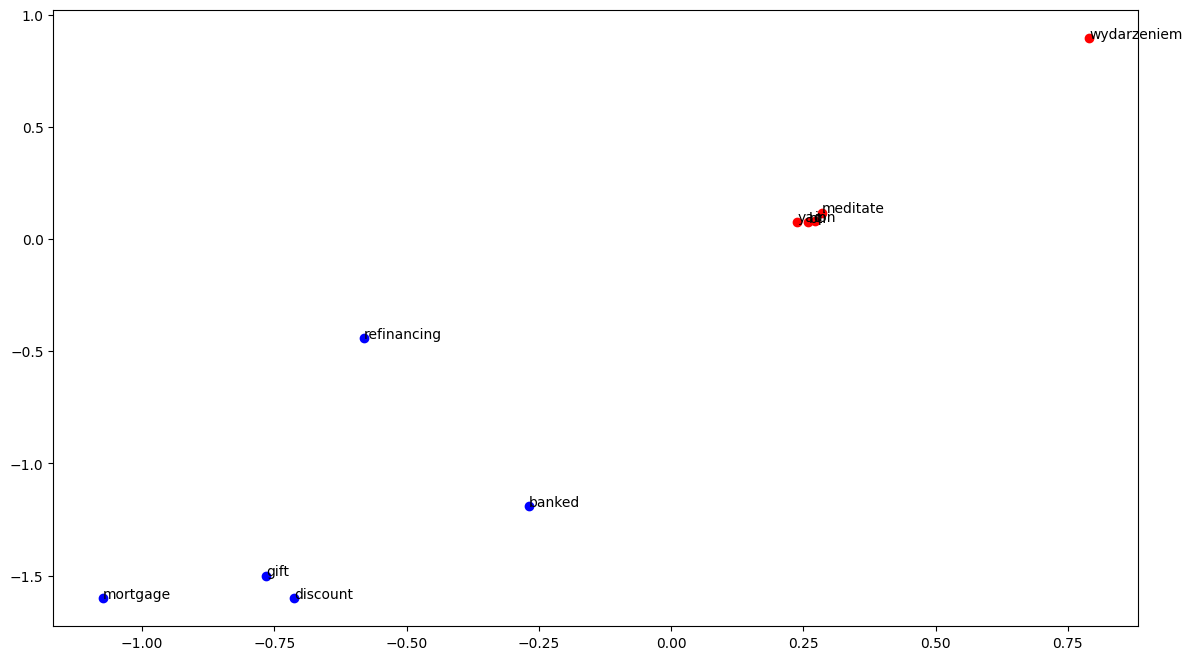

In [55]:
prog_near = np.argsort([ 
    euclidean(
        u[word2int("discount")], 
        u[i]
    ) for i in range(len(u))
])[:5]

random = np.random.choice(list(range(len(u))), size=5, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(u[i,0], u[i,1], c="b") #int2word(i))
    plt.text(u[i,0], u[i,1],int2word(i))
    
for i in random:
    plt.scatter(u[i,0], u[i,1], c="r") 
    plt.text(u[i,0], u[i,1],int2word(i))

In [56]:
np.save("./data/cbow_vectors.npy", embed_vectors)

### Negative Sampling Optimization

In [11]:
wsize=4
EMB_SIZE=50
k=10
vocab = list(all_words.values())

In [12]:
ds = get_dataset(emails, wsize)

In [13]:
context_words, target_words = unwind(ds)

In [14]:
context_words.shape

(204009, 8)

In [15]:
def epochs_generator(context_words, target_words, n_nsamples, batch_size=1):
    idx = np.arange(context_words.shape[0], dtype=int)
    np.random.shuffle(idx)
    context_words = context_words[idx]
    target_words = target_words[idx]    
    
    i = 0
    while i < int(context_words.shape[0]):
        c = context_words[i:i+batch_size]
        t = target_words[i:i+batch_size]
        
        new_shape = len(c)
        
        n_targets = np.array(
            choices(vocab, k=n_nsamples*new_shape)
        ).reshape(n_nsamples, new_shape)
        
        c = c.reshape(new_shape,-1)
        t = t.reshape(new_shape,-1)
        n = n_targets.reshape(new_shape,-1)

        out = np.array([[1] + [0]*n_nsamples]*new_shape).reshape(new_shape,-1)
        yield ([c, t, n], out)
        i+=batch_size

In [107]:
@tf.function
def cbow_loss(y_test, preds):
    return tf.reduce_sum(
        tf.math.log_sigmoid(preds)
    )

In [56]:
context = layers.Input(shape=wsize*2)
target = layers.Input(shape=1)
n_targets = layers.Input(shape=k)

embedding_layer = layers.Embedding(M, EMB_SIZE, name="emb_layer")
mean_layer = layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=(EMB_SIZE))
reshape_layer = layers.Reshape((1, EMB_SIZE))
dot_layer = layers.Dot(axes=2)
concat = layers.Concatenate()

cemb = embedding_layer(context)
cemb = mean_layer(cemb)
cemb = reshape_layer(cemb)

temb = embedding_layer(target)
nemb = embedding_layer(n_targets)

out = dot_layer([cemb, temb])
n_out = dot_layer([-cemb, nemb])

out = concat([out, n_out])

model = models.Model(inputs=[context, target, n_targets], outputs=out)

In [108]:
model.compile("adam", cbow_loss)

In [129]:
batch_size=8
model.fit(
    epochs_generator(context_words, target_words, k, batch_size),
    steps_per_epoch=np.ceil(len(context_words)/batch_size),
    epochs=1
)

25502/25502 [==============================] - 210s 8ms/step - loss: -17912.0898


In [130]:
embed_vectors = model.get_weights()[0]

In [138]:
np.save("./data/cbow_negative_vectors.npy", embed_vectors)

## Document Representation
- Each document will be reduced to a vector, which will be the mean of the words that appear in the document

In [30]:
EMB_SIZE=50

In [31]:
def get_existing_words(document, vocab):
    """
    Given a document, parses it's tokens, removing stopwords and punctuation;
    It also filters words that are not in the vocabulary
    """
    stopwords = set(map(str.lower, nltk.corpus.stopwords.words("english")))
    punctuation = set(string.punctuation)
    for word in nltk.tokenize.word_tokenize(document):
        word = word.lower()
        if (word not in stopwords) and \
        (word not in punctuation) and \
        (word in vocab):
            yield word

In [32]:
def get_doc_representation(corpus, emb_size, emb_vectors, vocab):
    vectors = []
    for doc in tqdm(corpus):
        vec = np.zeros(emb_size)
        wcount=0
        for sentence in nltk.tokenize.sent_tokenize(doc):
            for word in get_existing_words(sentence, vocab):
                vec += emb_vectors[ word2int(word) ]
                wcount+=1
        
        vectors.append(vec/wcount)
    return vectors

## Training/Testing the model

Using SVM since they are very robust

- GloVe Embeddingabs

In [ ]:
embed_vectors=np.load("./data/glove_vectors.npy")
train_vectors = np.array(
    get_doc_representation(X_train, EMB_SIZE, embed_vectors, all_words)
)
test_vectors = np.array(
    get_doc_representation(X_test, EMB_SIZE, embed_vectors, all_words)
)

In [ ]:
classifier = SVC().fit(train_vectors, y_train)
classifier.score(train_vectors, y_train)

In [ ]:
preds = classifier.predict(test_vectors)

In [38]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       885
           1       0.88      0.90      0.89       261

    accuracy                           0.95      1146
   macro avg       0.93      0.93      0.93      1146
weighted avg       0.95      0.95      0.95      1146



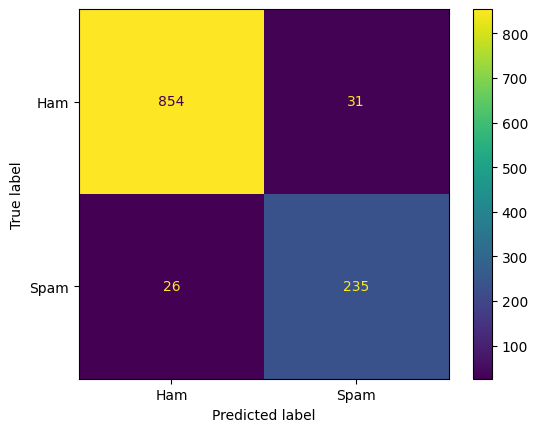

In [39]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test,preds), display_labels=["Ham", "Spam"]
).plot()

- CBOW Embedding

In [64]:
embed_vectors = np.load("./data/cbow_vectors.npy")
train_vectors = np.array(
    get_doc_representation(X_train, EMB_SIZE, embed_vectors, all_words)
)
test_vectors = np.array(
    get_doc_representation(X_test, EMB_SIZE, embed_vectors, all_words)
)

In [59]:
classifier = SVC().fit(train_vectors, y_train)
classifier.score(train_vectors, y_train)

0.9838498472282846

In [60]:
preds = classifier.predict(test_vectors)

In [61]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       885
           1       0.93      0.95      0.94       261

    accuracy                           0.97      1146
   macro avg       0.96      0.96      0.96      1146
weighted avg       0.97      0.97      0.97      1146



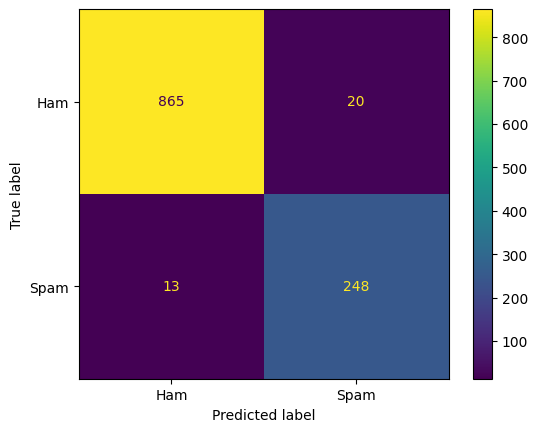

In [62]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test,preds), display_labels=["Ham", "Spam"]
).plot()

- CBOW Embedding with Negative Sampling

In [136]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       885
           1       0.78      0.63      0.69       261

    accuracy                           0.87      1146
   macro avg       0.84      0.79      0.81      1146
weighted avg       0.87      0.87      0.87      1146



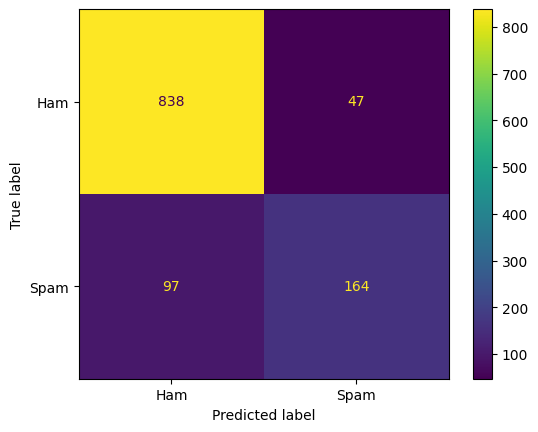

In [137]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test,preds), display_labels=["Ham", "Spam"]
).plot()